<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BRioBranco%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://raw.githubusercontent.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/master/DadosDiarios/rjdiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,25906.0,25906.000000,12758.000000,11478.000000,12542.000000,12300.000000,11373.000000,11266.000000,9677.000000,12624.000000,0.0
mean,82915.0,591.059986,5.515912,31.613278,20.811609,4.958537,2.076682,25.253191,85.043815,1.082437,NaN
std,0.0,599.944972,12.650449,2.798704,2.656088,3.181764,1.500666,1.926011,6.880615,0.769347,NaN
min,82915.0,0.000000,0.000000,14.700000,2.600000,0.000000,0.000000,10.500000,46.250000,0.000000,NaN
25%,82915.0,0.000000,0.000000,30.300000,19.600000,2.200000,1.100000,24.560000,81.250000,0.666667,NaN
50%,82915.0,0.000000,0.000000,32.000000,21.600000,5.000000,1.700000,25.560000,85.750000,1.000000,NaN
75%,82915.0,1200.000000,4.200000,33.400000,22.600000,7.700000,2.500000,26.400000,90.000000,1.371840,NaN
max,82915.0,1200.000000,135.200000,39.200000,29.200000,14.900000,17.700000,30.440000,100.000000,6.466667,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,82915,1980-01-01,0,NaN,31.5,NaN,0.0,0.8,24.90,NaN,0.0,NaN
1,82915,1980-01-01,1200,18.5,NaN,19.8,NaN,NaN,NaN,NaN,NaN,NaN
2,82915,1980-01-02,0,NaN,32.3,NaN,3.3,1.2,26.62,81.75,0.0,NaN
3,82915,1980-01-02,1200,0.0,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN
4,82915,1980-01-03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,11478.000000,0.0,12300.000000,11373.000000,11266.000000,9677.000000,12624.000000
mean,NaN,31.613278,NaN,4.958537,2.076682,25.253191,85.043815,1.082437
std,NaN,2.798704,NaN,3.181764,1.500666,1.926011,6.880615,0.769347
min,NaN,14.700000,NaN,0.000000,0.000000,10.500000,46.250000,0.000000
25%,NaN,30.300000,NaN,2.200000,1.100000,24.560000,81.250000,0.666667
50%,NaN,32.000000,NaN,5.000000,1.700000,25.560000,85.750000,1.000000
75%,NaN,33.400000,NaN,7.700000,2.500000,26.400000,90.000000,1.371840
max,NaN,39.200000,NaN,14.900000,17.700000,30.440000,100.000000,6.466667


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,12758.000000,0.0,12542.000000,0.0,0.0,0.0,0.0,0.0
mean,5.515912,NaN,20.811609,NaN,NaN,NaN,NaN,NaN
std,12.650449,NaN,2.656088,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,2.600000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,19.600000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,21.600000,NaN,NaN,NaN,NaN,NaN
75%,4.200000,NaN,22.600000,NaN,NaN,NaN,NaN,NaN
max,135.200000,NaN,29.200000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,31.5,0.0,0.8,24.90,NaN,0.0
1980-01-02,32.3,3.3,1.2,26.62,81.75,0.0
1980-01-03,NaN,NaN,NaN,NaN,NaN,1.0
1980-01-04,33.1,0.0,1.5,25.90,87.25,0.0
1980-01-05,NaN,NaN,NaN,NaN,NaN,1.0


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,18.5,19.8
1980-01-02,0.0,21.0
1980-01-04,13.6,21.0
1980-01-06,7.2,21.0
1980-01-07,2.4,21.0


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,31.5,0.0,0.8,24.90,NaN,0.0,18.5,19.8
1980-01-02,32.3,3.3,1.2,26.62,81.75,0.0,0.0,21.0
1980-01-03,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1980-01-04,33.1,0.0,1.5,25.90,87.25,0.0,13.6,21.0
1980-01-05,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,11478.000000,12300.000000,11373.000000,11266.000000,9677.000000,12624.000000,12758.000000,12542.000000
mean,31.613278,4.958537,2.076682,25.253191,85.043815,1.082437,5.515912,20.811609
std,2.798704,3.181764,1.500666,1.926011,6.880615,0.769347,12.650449,2.656088
min,14.700000,0.000000,0.000000,10.500000,46.250000,0.000000,0.000000,2.600000
25%,30.300000,2.200000,1.100000,24.560000,81.250000,0.666667,0.000000,19.600000
50%,32.000000,5.000000,1.700000,25.560000,85.750000,1.000000,0.000000,21.600000
75%,33.400000,7.700000,2.500000,26.400000,90.000000,1.371840,4.200000,22.600000
max,39.200000,14.900000,17.700000,30.440000,100.000000,6.466667,135.200000,29.200000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,31.5,0.0,0.8,24.90,NaN,0.0,18.5,19.8
1980-01-02,32.3,3.3,1.2,26.62,81.75,0.0,0.0,21.0
1980-01-03,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1980-01-04,33.1,0.0,1.5,25.90,87.25,0.0,13.6,21.0
1980-01-05,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-01,0.0,0.8,24.90,NaN,0.0,18.5,19.8
1980-01-02,3.3,1.2,26.62,81.75,0.0,0.0,21.0
1980-01-04,0.0,1.5,25.90,87.25,0.0,13.6,21.0
1980-01-06,0.0,1.6,25.86,87.75,1.0,7.2,21.0
1980-01-07,2.2,1.2,26.02,88.50,2.0,2.4,21.0


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-01    31.5
1980-01-02    32.3
1980-01-04    33.1
1980-01-06    32.1
1980-01-07    30.5
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,11042.000000,10135.000000,11260.000000,8542.000000,11078.000000,11468.000000,11268.000000
mean,-0.324833,-0.762584,0.479915,0.449851,-0.663772,-0.917811,0.237645
std,0.429450,0.174605,0.192939,0.259437,0.232647,0.188497,0.242419
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.691275,-0.875706,0.410231,0.311628,-0.793814,-1.000000,0.127273
50%,-0.315436,-0.807910,0.510532,0.479070,-0.690722,-1.000000,0.309091
75%,0.060403,-0.706215,0.594784,0.627907,-0.575720,-0.936391,0.400000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(11478, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 773.0745 - mean_absolute_error: 27.5768
Epoch 2/200
 - 1s - loss: 465.2635 - mean_absolute_error: 21.3307
Epoch 3/200
 - 1s - loss: 270.8005 - mean_absolute_error: 16.1557
Epoch 4/200
 - 1s - loss: 143.8938 - mean_absolute_error: 11.6176
Epoch 5/200
 - 1s - loss: 67.8058 - mean_absolute_error: 7.7619
Epoch 6/200
 - 1s - loss: 28.5229 - mean_absolute_error: 4.8029
Epoch 7/200
 - 1s - loss: 12.7209 - mean_absolute_error: 3.0237
Epoch 8/200
 - 1s - loss: 8.4204 - mean_absolute_error: 2.2919
Epoch 9/200
 - 1s - loss: 7.7792 - mean_absolute_error: 2.1130
Epoch 10/200
 - 1s - loss: 7.7427 - mean_absolute_error: 2.0844
Epoch 11/200
 - 1s - lo

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.743509, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.743509 (0.094163) {'batch_size': 10, 'camadas': 2, 'units': 7}


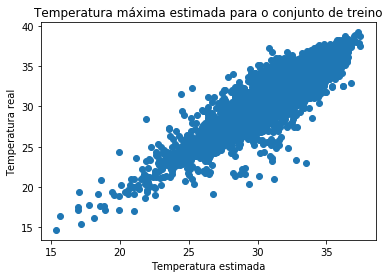

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.89127846]
 [0.89127846 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

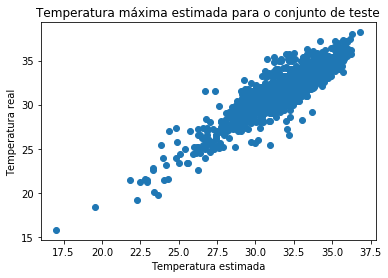

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.        0.8942769]
 [0.8942769 1.       ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.9785354401591763


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

1.6345762817042504


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-01,31.5,0.0,0.8,24.90,NaN,0.0,18.5
1980-01-02,32.3,3.3,1.2,26.62,81.75,0.0,0.0
1980-01-04,33.1,0.0,1.5,25.90,87.25,0.0,13.6
1980-01-06,32.1,0.0,1.6,25.86,87.75,1.0,7.2
1980-01-07,30.5,2.2,1.2,26.02,88.50,2.0,2.4


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-01    19.8
1980-01-02    21.0
1980-01-04    21.0
1980-01-06    21.0
1980-01-07    21.0
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,11268.000000,12244.000000,11171.000000,11229.000000,9625.000000,12185.000000,12540.000000
mean,0.380745,-0.335046,-0.767261,0.414125,0.443263,-0.665847,-0.918110
std,0.228105,0.426968,0.168149,0.214512,0.256295,0.238220,0.187597
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.273469,-0.704698,-0.875706,0.334088,0.302326,-0.793814,-1.000000
50%,0.412245,-0.328859,-0.807910,0.447339,0.469767,-0.690722,-1.000000
75%,0.526531,0.033557,-0.717514,0.542469,0.627907,-0.575720,-0.937870
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(12542, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 285.8452 - mean_absolute_error: 16.5370
Epoch 2/200
 - 1s - loss: 115.7542 - mean_absolute_error: 10.3322
Epoch 3/200
 - 1s - loss: 41.6546 - mean_absolute_error: 5.9731
Epoch 4/200
 - 1s - loss: 14.3504 - mean_absolute_error: 3.3657
Epoch 5/200
 - 1s - loss: 7.8722 - mean_absolute_error: 2.3465
Epoch 6/200
 - 1s - loss: 7.1151 - mean_absolute_error: 2.0887
Epoch 7/200
 - 1s - loss: 7.0869 - mean_absolute_error: 2.0431
Epoch 8/200
 - 1s - loss: 7.0961 - mean_absolute_error: 2.0392
Epoch 9/200
 - 1s - loss: 7.0519 - mean_absolute_error: 2.0419
Epoch 10/200
 - 1s - loss: 6.4287 - mean_absolute_error: 1.9904
Epoch 11/200
 - 1s - loss: 4.1783 - mean_absolute_error: 1.5706
Epoch 12/200
 - 1s - loss: 2.8882 - mean_absolute_error: 1.2588
Epoch 13/200
 - 1s - l

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.928678, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.928678 (0.102198) {'batch_size': 10, 'camadas': 2, 'units': 7}


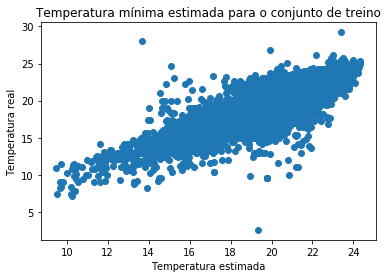

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.86653882]
 [0.86653882 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

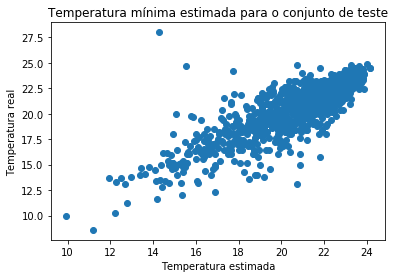

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.84354151]
 [0.84354151 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.9377372270561309


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

1.896484760468861


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaRioBranco.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaRioBranco.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))